# Figure 1


In [130]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point


C:\Users\Yasaman\AppData\Local\Temp\ipykernel_24764\4154922300.py:35: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
c:\Users\Yasaman\anaconda3\Lib\site-packages\geopandas\geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\Yasaman\AppData\Local\Temp\ipykernel_24764\4154922300.py:57: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before thi

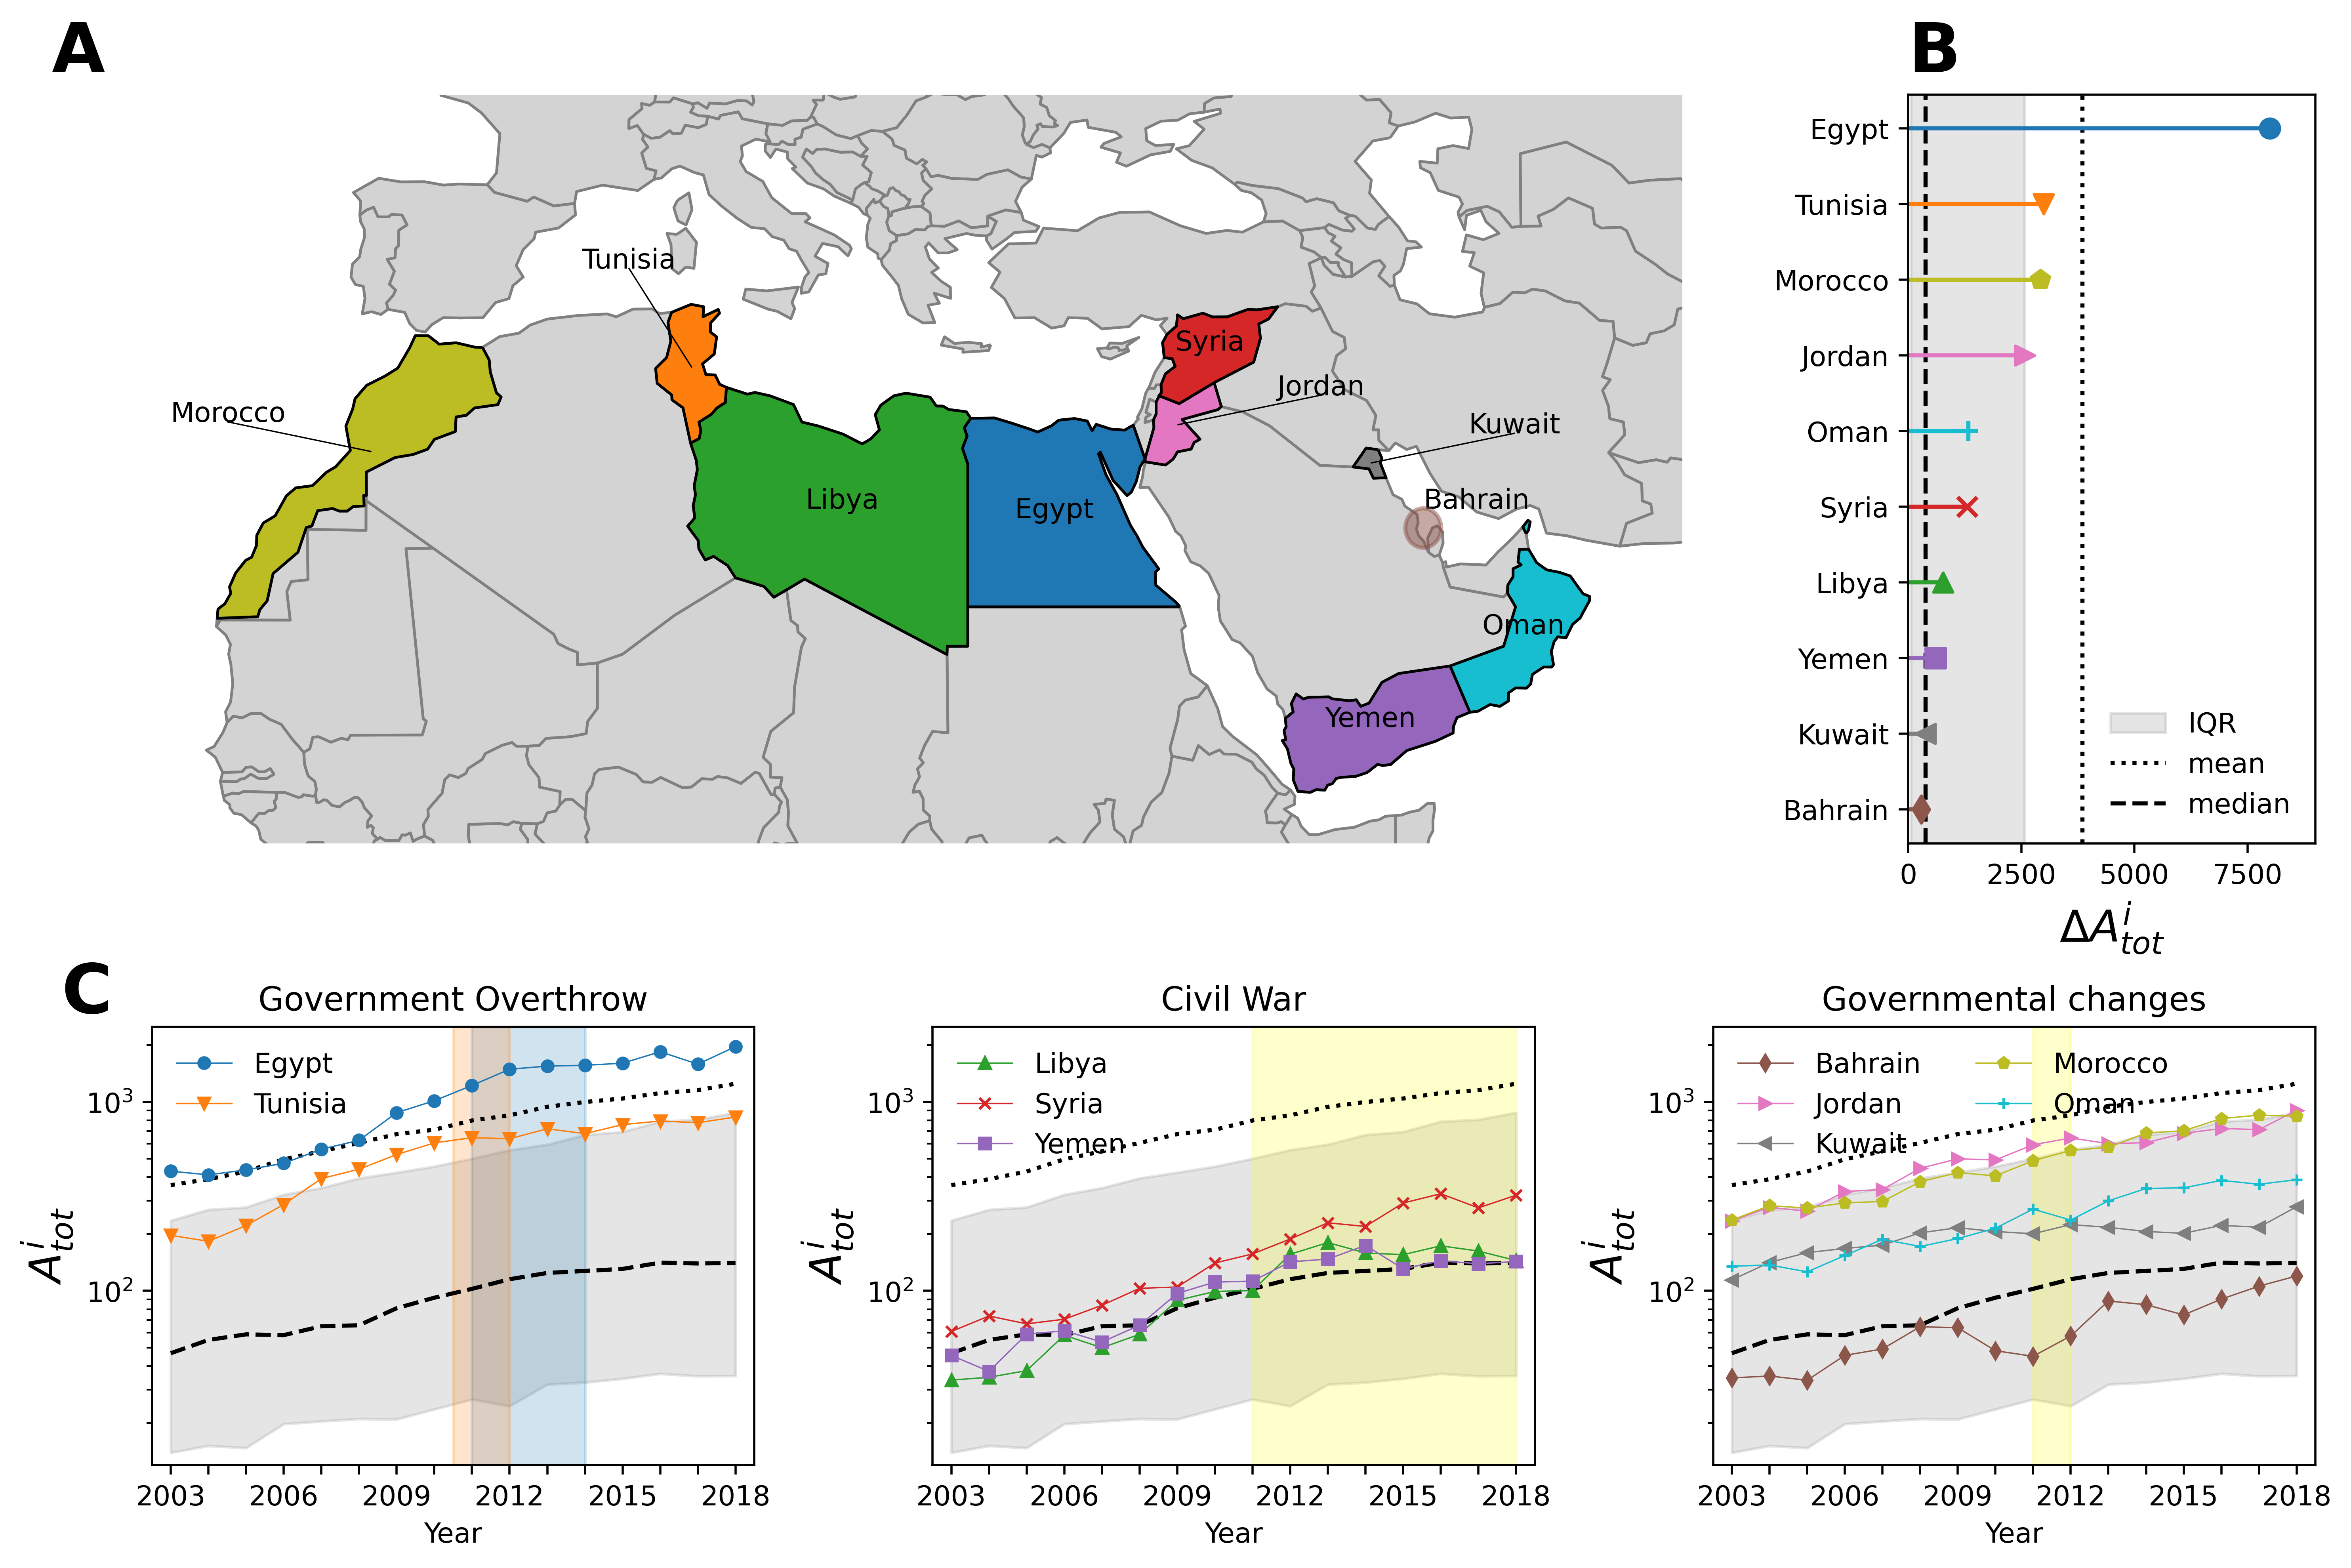

In [309]:
# Create a new figure with custom subplot layout
fig = plt.figure(figsize=(12, 8), dpi=500)

# Create grid specification for subplots
gs = fig.add_gridspec(5, 12)


# Define the subplots based on the grid specification
# Four plots on the top row

ax1 = fig.add_subplot(gs[0:3, 0:9])
ax1.text(-0.1, 1.1, 'A', transform=ax1.transAxes, verticalalignment='top', fontsize=25,fontweight='bold')
subplot_A(ax1)


ax2 = fig.add_subplot(gs[0:3, 9:])
ax2.text(-0.0, 1.1, 'B', transform=ax2.transAxes, verticalalignment='top', fontsize=25,fontweight='bold')
subplot_B(ax2)
ax2.set_xlabel('$\Delta A^i_{tot}$', fontsize=16)




ax3 = fig.add_subplot(gs[3:, 0:4])
ax3.text(-0.15, 1.15, 'C', transform=ax3.transAxes, verticalalignment='top', fontsize=25,fontweight='bold')



ax4 = fig.add_subplot(gs[3:, 4:8])
ax5 = fig.add_subplot(gs[3:, 8:12])
plotC([ax3, ax4, ax5])

ax4.set_yticklabels([])
ax5.set_yticklabels([])

ax3.set_title('Government Overthrow')
ax4.set_title('Civil War')
ax5.set_title('Governmental changes')

for axis in [ax3, ax4, ax5]:
    axis.set_xlabel('Year')
    axis.set_yscale('log')
    axis.set_ylim(12, 2500)
    axis.set_ylabel('$A^i_{tot}$', fontsize=16)



fig.tight_layout()
fig.savefig('Figure1.pdf')

In [265]:
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.patches as mpatches

def subplot_A(ax):
    # Define the observed colors for MENA countries from the uploaded map
    country_colors_manual = {
        'EGY': 'C0',  # Egypt
        'TUN': 'C1',  # Tunisia
        'LBY': 'C2',  # Libya 
        'SYR': 'C3',  # Syria
        'YEM': 'C4',  # Yemen
        'BHR': 'C5',  # Bahrain
        'JOR': 'C6',  # Jordan
        'KWT': 'C7',  # Kuwait
        'MAR': 'C8',  # Morocco
        'OMN': 'C9',  # Oman
    }

    # Define full country names
    country_full_names = {
        'EGY': 'Egypt',
        'LBY': 'Libya',
        'TUN': 'Tunisia',
        'SYR': 'Syria',
        'YEM': 'Yemen',
        'MAR': 'Morocco',
        'OMN': 'Oman',
        'BHR': 'Bahrain',
        'KWT': 'Kuwait',
        'JOR': 'Jordan',
    }

    # Load the world map data
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

    # Filter MENA countries
    mena = world[world['iso_a3'].isin(country_colors_manual.keys())]

    # Assign colors to each country based on the manual mapping
    mena['color'] = mena['iso_a3'].map(country_colors_manual)

    # Define the bounding box for the MENA region and its neighbors
    lat_min, lat_max = 10, 48
    lon_min, lon_max = -18, 65

    # Plot countries
    world.cx[lon_min:lon_max, lat_min:lat_max].plot(ax=ax, color="lightgrey", edgecolor="gray")  # Rest of the countries in white
    mena.plot(ax=ax, color=mena['color'], edgecolor="black")  # MENA countries with custom colors

    # Add country names and special handling for small countries
    for iso_code, full_name in country_full_names.items():
        country = mena[mena['iso_a3'] == iso_code]
        if country.empty:
            continue
        
        centroid = country.geometry.centroid.iloc[0]

        if full_name in ['Morocco', 'Jordan', 'Kuwait', 'Tunisia']:
            # Offset labels for smaller countries
            if full_name == 'Morocco':
                label_point = Point(centroid.x - 8, centroid.y + 1.5)
            elif full_name == 'Tunisia':
                label_point = Point(centroid.x-3.5, centroid.y + 5)
            else:
                label_point = Point(centroid.x + 8, centroid.y + 1.5)
            
            ax.plot([centroid.x, label_point.x], [centroid.y, label_point.y], color="black", lw=0.5)
        else:
            if full_name in ['Egypt', 'Yemen', 'Libya']:
                label_point = Point(centroid.x, centroid.y) 
            else: 
                 label_point=centroid# Default label at the centroid
        
        # Add the text label
        ax.text(label_point.x, label_point.y, full_name, fontsize=10, ha='center', color='black')

    circle = mpatches.Circle((50.5, 26), 1, edgecolor='C5', facecolor='C5', lw=1.5, zorder=5, alpha=0.5)  # Add circle
    ax.add_patch(circle)
    ax.text(50.5, 27, 'Bahrain', fontsize=10, ha='left', color='black')

    # Highlight the bounding box
    ax.set_xlim(lon_min, lon_max)
    ax.set_ylim(lat_min, lat_max)
    ax.axis("off")


In [158]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

world[world['name']=='Bahrain']

C:\Users\Yasaman\AppData\Local\Temp\ipykernel_24764\431413383.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


,pop_est,continent,name,iso_a3,gdp_md_est,geometry


In [300]:
def plotC(axis):
    # Load and preprocess data
    df = pd.read_csv(r"C:\Users\Yasaman\Downloads\Attention-fractional counting.csv")
    df.rename(columns={'aggregated_value': 'count', 'country': 'Mention_country', 'affiliation_country': 'Aff_country'}, inplace=True)
    df = df[df['year'].isin(range(2003, 2019))]

    # Country and unrest information
    country_codes = {'Egypt': 'EGY', 'Tunisia': 'TUN', 'Libya': 'LBY', 'Syria': 'SYR', 'Yemen': 'YEM', 'Bahrain': 'BHR',
                     'Jordan': 'JOR', 'Kuwait': 'KWT', 'Morocco': 'MAR', 'Oman': 'OMN'}
    reverse_country_codes = {v: k for k, v in country_codes.items()}
    unrest_periods = {
        'Egypt': [(2011, 2014)], 'Tunisia': [(2010.5, 2012)], 'Yemen': [(2011, 2017)], 'Syria': [(2011, 2017)],
        'Libya': [(2011, 2017)], 'Bahrain': [(2011, 2011)], 'Kuwait': [(2011, 2011)], 'Morocco': [(2011, 2011)],
        'Oman': [(2011, 2011)], 'Jordan': [(2011, 2011)]
    }

    def calculate_group_metrics(df):
        """Calculate aggregated metrics for the data."""
        mention_country_totals = df.groupby(['year', 'Mention_country'])['count'].sum().reset_index()
        mention_country_totals.rename(columns={'count': 'count_mention_country'}, inplace=True)

        yearly_totals = df.groupby('year')['count'].sum().reset_index()
        yearly_totals.rename(columns={'count': 'total_count'}, inplace=True)

        df = df.merge(mention_country_totals, on=['year', 'Mention_country'])
        df = df.merge(yearly_totals, on='year')

        aggregated_df = df.drop_duplicates(['year', 'Mention_country'])[['year', 'Mention_country', 'count_mention_country', 'total_count']]
        aggregated_df.rename(columns={'Mention_country': 'countrycode'}, inplace=True)

        return aggregated_df

    def plot_time_series(df, column, ax, show_mean=True, show_legend=True, show_unrest=True):
        """Plot time series data."""
        country_groups = [['egy', 'tun'], ['lby', 'syr', 'yem'], ['bhr', 'jor', 'kwt', 'mar', 'omn']]

        # Compute statistics
        stats = {
            'mean': df.groupby('year')[column].mean(),
            'median': df.groupby('year')[column].median(),
            'q25': df.groupby('year')[column].quantile(0.25),
            'q75': df.groupby('year')[column].quantile(0.75)
        }

        marker_styles = ['o', 'v', '^', 'x', 's', 'd', '>', '<', 'p', '+']
        color_counter = 0

        for idx, group in enumerate(country_groups):
            if show_mean:
                ax[idx].plot(stats['mean'].index, stats['mean'], linestyle=':', color='k')
            ax[idx].plot(stats['median'].index, stats['median'], linestyle='--', color='k')
            ax[idx].fill_between(stats['median'].index, stats['q25'], stats['q75'], color='grey', alpha=0.2)

            for country in group:
                country_df = df[df['countrycode'] == country]
                ax[idx].plot(country_df['year'], country_df[column], label=reverse_country_codes[country.upper()],
                             color=f'C{color_counter}', marker=marker_styles[color_counter], markersize=4, linewidth=0.5)
                color_counter += 1
                if idx ==0:
                  for start, end in unrest_periods.get(reverse_country_codes[country.upper()], []):
                      ax[idx].axvspan(start, end , alpha=0.2, color=f'C{color_counter - 1}')
            if idx !=0:
                  for start, end in unrest_periods.get(reverse_country_codes[country.upper()], []):
                      ax[idx].axvspan(start, end + 1, alpha=0.2, color='Yellow')
                    

            if idx ==2:
                ax[idx].legend(loc='upper left', frameon=False, ncol=2)
            else:
                
                ax[idx].legend(loc='upper left', frameon=False)

            ax[idx].set_xticks(range(2003, 2019))
            ax[idx].set_xticklabels([str(tick) if year % 3 == 0 else '' for year, tick in enumerate(range(2003, 2019))])
            ax[idx].set_xlabel('Year')
            ax[idx].set_xlim(2002.5, 2018.5)

    # Filter out physical sciences and process data
    physical_sciences = ['MATH', 'ENGI', 'PHYS', 'COMP']
    df = df[~df['subjarea'].isin(physical_sciences)]
    aggregated_data = calculate_group_metrics(df)
    aggregated_data.sort_values(by='year', inplace=True)

    # Plot data
    plot_time_series(aggregated_data, 'count_mention_country', ax=axis)


In [307]:
def subplot_B(ax):
    df=pd.read_csv(r"C:\Users\Yasaman\Downloads\Attention-fractional counting.csv")
    df=df.rename(columns={'year':'Year', 'aggregated_value':'count', 'country':'Mention_country', 'affiliation_country':'Aff_country'})
    Country_list={'Egypt':'EGY', 'Tunisia':'TUN','Libya':'LBY','Syria':'SYR','Yemen':'YEM','Bahrain':'BHR','Jordan':'JOR','Kuwait':'KWT','Morocco':'MAR','Oman':'OMN'}
    rev_Country_list={Country_list[key]: key for key in Country_list}
    abbr=[country.lower() for country in Country_list.values()]
    physical_sciences=[ 'MATH', 'ENGI', 'PHYS', 'COMP']
    df=df[~df['subjarea'].isin(physical_sciences)]
    df=df.groupby(['Year', 'Mention_country', 'Aff_country'])['count'].sum().reset_index()
    
    country_codes=pd.read_csv(r"C:\Users\Yasaman\Downloads\iso3.csv")
    country_codes['iso3']=[c.lower() for c in country_codes['iso3']]
    Map={country_codes.iloc[c]['iso3']: country_codes.iloc[c]['name'] for c in range(len(country_codes))}
    Map['irn']='Iran'
    Map['usa']='USA'
    Map['gbr']='UK'
    Map['syr']='Syria'
    
    # Define year ranges for "before" and "after" data.
    years_before = np.arange(2003, 2011, 1)
    years_after = np.arange(2011, 2019, 1)
    


    # Function to calculate summary statistics for given years and data.
    def summarize_years(df, years, abbr):
        # Filter the DataFrame for the given years range.
        df_filtered = df[(df['Year'].isin(years))]
        # Sum of counts by affiliation country.
        summary_df = df_filtered.groupby(['Aff_country','Mention_country'])['count'].sum().reset_index()

        return summary_df.fillna(0)  # Fill NaN with 0 if any.

    # Apply the function to both year ranges.
    before_df = summarize_years(df, years_before, abbr)
    before_df = before_df.add_suffix('_before')

    after_df = summarize_years(df, years_after, abbr)
    after_df = after_df.add_suffix('_after')


    full_df = before_df.merge(after_df, left_on=['Aff_country_before','Mention_country_before'], right_on=['Aff_country_after','Mention_country_after'], how='outer')
    full_df.fillna(0, inplace=True)
    full_df['Mention_country'] = np.where(full_df['Mention_country_before'] != 0, full_df['Mention_country_before'], full_df['Mention_country_after'])
    full_df['Aff_country'] = np.where(full_df['Aff_country_before'] != 0, full_df['Aff_country_before'], full_df['Aff_country_after'])
    full_df.drop(columns=['Aff_country_before','Mention_country_before','Mention_country_after','Aff_country_after'], inplace=True)
    
    result_df=full_df.groupby('Mention_country')[['count_after', 'count_before']].sum().reset_index()

    #result_df['count_after']/=len(years_before)
    #result_df['count_before']/=len(years_before)
    result_df['Absolute difference']=result_df['count_after']-result_df['count_before']

    col='Absolute difference'
    markers=['o', 'v', '^', 'x', 's', 'd', '>', '<', 'p', '+']
    copy_df = result_df[result_df['Mention_country'].isin(abbr)]
    copy_df=copy_df.sort_values(by=col, ascending=True).reset_index(drop=True)

    country_names=['egy','tun', 'lby', 'syr', 'yem', 'bhr', 'jor', 'kwt', 'mar', 'omn']
   # sns.boxplot(result_df, y='Absolute difference', ax=ax,log_scale=(False,True), color='lightgrey')
    ax.axvspan(result_df[col].quantile(0.25), result_df[col].quantile(0.75), alpha=0.2 , color='grey', label='IQR')
    ax.axvline(result_df[col].mean(), linestyle=':', label='mean', color='k')
    ax.axvline(result_df[col].median(), linestyle='--', label='median', color='k')
    
    for i, country in enumerate(country_names):
        val=copy_df[copy_df['Mention_country']==country][col].values[0]
        index=copy_df[copy_df['Mention_country']==country][col].index[0]
        ax.scatter([val], [index], color=f'C{i}', marker=markers[i],zorder=3, s=50)
        ax.axhline(index, color=f'C{i}', xmin=0, xmax=val/9000)
    #ax.stem(countries ,values, basefmt=" ", use_line_collection=True,orientation='horizontal')  # 'basefmt' hides the baseline

    ax.legend( frameon=False)
    ax.set_yticks(np.arange(len(copy_df)))
    ax.set_yticklabels([Map[j] for j in copy_df['Mention_country'].values])
    ax.set_xlim(0, 9000)

    
    